# R and Python Analytics via Jupyter, Reticulate, and BigFix

SYNOPSIS:
------------
This notebook (an R session which calls Python 'helper-routines' from **configNqueryCmdline.py**) demonstrates interaction between R and Python programs and dataframes, showing the best features of both languages.

The program opens and reads credentials & URL from  a configuration-file (credentials.json), creates a BigFix 'query-channel', and extracts endpoint information from the BigFix management server, to be manipulated and graphed using R libraries.

![Sample ggplot graph from BF query](LifetimeVsNumEndpoints-ADHAY.png)


In [160]:
# First Look for credentials.json in the parent directory listing
list.files('..')

[1] "add.py"                                                                                                   
 [2] "baseline_template.bes"                                                                                    
 [3] "baselineActionReport.bes"                                                                                 
 [4] "bfClientSetting"                                                                                          
 [5] "completedBaseline.bes"                                                                                    
 [6] "configNquery"                                                                                             
 [7] "configNquery.ipynb"                                                                                       
 [8] "configNquery.py"                                                                                          
 [9] "createComputerGroup.py"                                                                                   
[10] "createComputerGroup2.py"                                                                                  
[11] "credentials.json"                                                                                         
[12] "cycleGather.py"                                                                                           
[13] "cycleGather.xml"                                                                                          
[14] "doc"                                                                                                      
[15] "executeActionList4IEM.py"                                                                                 
[16] "file.xml"                                                                                                 
[17] "fixedFixlets.txt"                                                                                         
[18] "getAssetsNCheckinTime.py"                                                                                 
[19] "getFixlets2DictUrllib3.py"                                                                                
[20] "getFixletsRest.py"                                                                                        
[21] "getFixletsRest2File.py"                                                                                   
[22] "getFixletsRest2File2.py"                                                                                  
[23] "getFixletsRestAdonix.py"                                                                                  
[24] "getFixletsRestAdonixUrllib.py"                                                                            
[25] "getFixletsRestGrass.py"                                                                                   
[26] "Grasskeet-CriticalVulns-baseline.bes"                                                                     
[27] "importTweedleDeeFixlet.py"                                                                                
[28] "importTweedleDeeFixlet3.py"                                                                               
[29] "invokeBesProvisioning.xml"                                                                                
[30] "InvokeFixletRestViaPython.docx"                                                                           
[31] "InvokeFixletRestViaPython.pdf"                                                                            
[32] "InvokeFixletRestViaPython2.pdf"                                                                           
[33] "Li3000.txt"                                                                                               
[34] "MasterSite_FixletA.bes"                                                                                   
[35] "MasterSite_FixletB.bes"                                                                                   
[36] "MS11-092_ Vulnerability in Windows Media

**install/instantiate Reticulate library using install.packages('reticulate') and library('reticulate'), then 'pull in' configNqueryCmdline.py**

In [171]:
# install.packages('reticulate')
library("reticulate")
source_python("rdConfigNqueryBF.py")

**As a first pass, just get some computer names from BigFix and print them out**

In [172]:
# First-Pass: Set up and read the credentials-file, returning the configuration-dictionary
rCfg<-"../credentials.json"
myCfg<-readConfig(rCfg)

# Create a 'relevance string and query the BigFix server about computers containing 'adhay' in their hostnames
newRelevance<-"names of bes computers"

# Use configuration and relevance to query BigFix
xmlResult<-queryBFviaRelevance(myCfg,newRelevance)
#print(xmlResult)

# Using a lambda function defined for the purpose of parsing the bes computers XML, 
# print out the first 6 elements of the DataFrame
print(head(computersLf1(xmlResult)))

           0
1    A206915
2    A206904
3  VBT222-28
4    A122443
5 ADHAYGAP21
6    A206607


**As a second pass, get a particular set of computer names, but also include their last 'checkin time'**

In [173]:
# Second-Pass:
# Create a 'relevance string and query the BigFix server 
# We're looking for all endpoints containing "ADHAY" in the name and their last checkin time
# (notice encoding of double-quote and ampersand characters)
newRelevance<-"(name of it %26 %22>%22 %26 (last report time of it) as string) of bes computers whose (name of it as lowercase contains %22adhay%22)"
xmlResult<-queryBFviaRelevance(myCfg,newRelevance)

# Using the second lambda function we defined for parsing bes computers, 
# return a dataframe of tuples split by ">"
df0<-computersLf2(xmlResult)

# Now clean up the data & rename the columns appropriately, displaying a sample
names(df0)<-c("Endpoint Name","Last Checkin Time")
head(df0)

# Let's see how many tuples we have...
str(df0)

Endpoint Name,Last Checkin Time
ADHAYGAP21,"Wed, 18 Jul 2018 11:36:29 -0700"
ADHAYVCR01,"Wed, 18 Jul 2018 11:39:36 -0700"
ADHAYFDB01,"Wed, 18 Jul 2018 11:03:06 -0700"
ADHAYMCS01N1,"Wed, 18 Jul 2018 11:31:05 -0700"
ADHAYGAP16,"Wed, 18 Jul 2018 11:40:01 -0700"
ADHAYWEB08,"Wed, 18 Jul 2018 11:30:22 -0700"


'data.frame':	144 obs. of  2 variables:
 $ Endpoint Name    : chr  "ADHAYGAP21" "ADHAYVCR01" "ADHAYFDB01" "ADHAYMCS01N1" ...
 $ Last Checkin Time: chr  "Wed, 18 Jul 2018 11:36:29 -0700" "Wed, 18 Jul 2018 11:39:36 -0700" "Wed, 18 Jul 2018 11:03:06 -0700" "Wed, 18 Jul 2018 11:31:05 -0700" ...
 - attr(*, "pandas.index")=RangeIndex(start=0, stop=144, step=1)


**Finally, let's get both their 'Last Report Time' and their 'First Report Time', displayed in a table**

In [174]:
# Third-Pass:
# Create a 'relevance string and query the BigFix server for all endpoints containing "ADHAY" in the name, 
# their last checkin time, and initial install date

# BTW, (notice the encoding of double-quotes (%22), ">" (%3e), and ampersand (%26) characters)
newRelevance<-"(name of it %26 %22%3e%22 %26 last report time of it as string %26 %22%3e%22 %26 (value of results (it, bes property %22InitialInstallDate%22) as string)) of bes computers whose
(name of it as lowercase contains %22adhay%22 and exists value of it of results (it, bes property %22InitialInstallDate%22))"

xmlResult<-queryBFviaRelevance(myCfg,newRelevance)

# Using the second lambda function we defined for parsing bes computers, 
# clean up the dataframe renaming columns to something descriptive, & display the first 6
df0<-computersLf2(xmlResult)
names(df0)<-c("Endpoint Name","Last Checkin Time", "Initial Install Date")
head(df0)

Endpoint Name,Last Checkin Time,Initial Install Date
ADHAYGAP21,"Wed, 18 Jul 2018 11:36:29 -0700","Wed, 27 Jul 2016 17:08:32 -0700"
ADHAYVCR01,"Wed, 18 Jul 2018 11:39:36 -0700","Wed, 08 Jun 2016 10:33:56 -0700"
ADHAYFDB01,"Wed, 18 Jul 2018 11:03:06 -0700","Sun, 20 Sep 2015 08:53:24 -0700"
ADHAYMCS01N1,"Wed, 18 Jul 2018 11:31:05 -0700","Sun, 20 Sep 2015 08:39:59 -0700"
ADHAYGAP16,"Wed, 18 Jul 2018 11:40:01 -0700","Thu, 16 Mar 2017 09:38:15 -0700"
ADHAYWEB08,"Wed, 18 Jul 2018 11:30:22 -0700","Tue, 02 May 2017 07:43:19 -0700"


** A few experiments to get the format right...**

In [188]:
dateFmt<-"%a, %d %b %Y %H:%M:%S %z"

In [189]:
LastReportTime <-as.Date(df0[1,"Last Checkin Time"],dateFmt)

In [190]:
InitialInstallDate <- as.Date(df0[1,"Initial Install Date"],dateFmt)

In [185]:
EndpointLifetime <- LastReportTime - InitialInstallDate

In [187]:
head(df0[,"Last Checkin Time"])

[1] "Wed, 18 Jul 2018 11:36:29 -0700" "Wed, 18 Jul 2018 11:39:36 -0700"
[3] "Wed, 18 Jul 2018 11:03:06 -0700" "Wed, 18 Jul 2018 11:31:05 -0700"
[5] "Wed, 18 Jul 2018 11:40:01 -0700" "Wed, 18 Jul 2018 11:30:22 -0700"

**OK, Let's calculate the number of days since install....**

In [206]:
df0$LastReportTimeDate<-as.Date(df0[,"Last Checkin Time"],dateFmt)
df0$InitialInstallDate<-as.Date(df0[,"Initial Install Date"],dateFmt)
df0$Lifetime<-df0$LastReportTimeDate-df0$InitialInstallDate
df0$LastReportTimeDate<-NULL
df0$InitialInstallDate<-NULL
head(df0)

Endpoint Name,Last Checkin Time,Initial Install Date,Lifetime
ADHAYGAP21,"Wed, 18 Jul 2018 11:36:29 -0700","Wed, 27 Jul 2016 17:08:32 -0700",720 days
ADHAYVCR01,"Wed, 18 Jul 2018 11:39:36 -0700","Wed, 08 Jun 2016 10:33:56 -0700",770 days
ADHAYFDB01,"Wed, 18 Jul 2018 11:03:06 -0700","Sun, 20 Sep 2015 08:53:24 -0700",1032 days
ADHAYMCS01N1,"Wed, 18 Jul 2018 11:31:05 -0700","Sun, 20 Sep 2015 08:39:59 -0700",1032 days
ADHAYGAP16,"Wed, 18 Jul 2018 11:40:01 -0700","Thu, 16 Mar 2017 09:38:15 -0700",489 days
ADHAYWEB08,"Wed, 18 Jul 2018 11:30:22 -0700","Tue, 02 May 2017 07:43:19 -0700",442 days


In [212]:
str(df0)

'data.frame':	141 obs. of  4 variables:
 $ Endpoint Name       : chr  "ADHAYGAP21" "ADHAYVCR01" "ADHAYFDB01" "ADHAYMCS01N1" ...
 $ Last Checkin Time   : chr  "Wed, 18 Jul 2018 11:36:29 -0700" "Wed, 18 Jul 2018 11:39:36 -0700" "Wed, 18 Jul 2018 11:03:06 -0700" "Wed, 18 Jul 2018 11:31:05 -0700" ...
 $ Initial Install Date: chr  "Wed, 27 Jul 2016 17:08:32 -0700" "Wed, 08 Jun 2016 10:33:56 -0700" "Sun, 20 Sep 2015 08:53:24 -0700" "Sun, 20 Sep 2015 08:39:59 -0700" ...
 $ Lifetime            :Class 'difftime'  atomic [1:141] 720 770 1032 1032 489 ...
  .. ..- attr(*, "units")= chr "days"
 - attr(*, "pandas.index")=RangeIndex(start=0, stop=141, step=1)


## Finally! A Useful Graph...

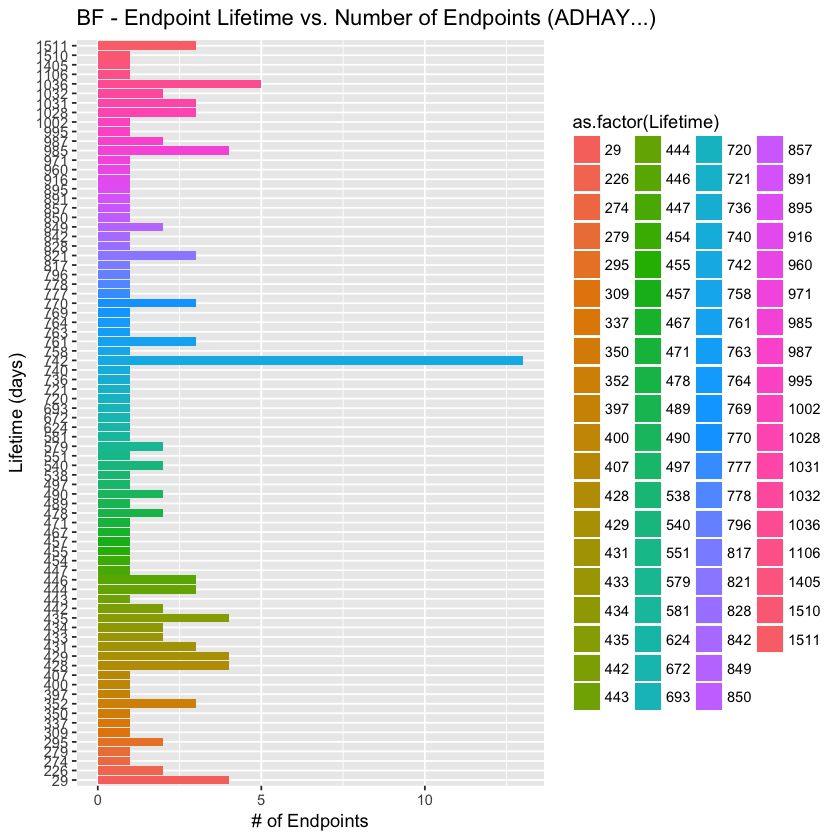

In [213]:
library('ggplot2')
ggplot(df0, aes(x=as.factor(Lifetime), fill=as.factor(Lifetime) )) +  geom_bar( ) + coord_flip() + labs(title="BF - Endpoint Lifetime vs. Number of Endpoints (ADHAY...)", x = "Lifetime (days)", y="# of Endpoints")